# EDA: E-commerce Fraud Data

This notebook performs exploratory data analysis on the e-commerce transaction fraud dataset.

## Objectives
1. Data cleaning and preprocessing
2. Univariate analysis: distributions of key variables
3. Bivariate analysis: relationships between features and target
4. Class distribution analysis: quantify the imbalance
5. Geolocation integration: IP address to country mapping


In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import ipaddress
from pathlib import Path

warnings.filterwarnings('ignore')

# Set up paths - ensure we're working from the project root
project_root = Path().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent
elif (project_root / 'notebooks').exists():
    pass  # Already at project root
else:
    # Try to find project root by looking for data directory
    current = Path().resolve()
    while current != current.parent:
        if (current / 'data').exists():
            project_root = current
            break
        current = current.parent

DATA_DIR = project_root / 'data' / 'raw'
OUTPUT_DIR = project_root / 'outputs' / 'eda' / 'fraud-data'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)  # Create output directory if it doesn't exist

print(f"Project root: {project_root}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Helper function to save plots
def save_plot(fig, filename, dpi=300, bbox_inches='tight'):
    """Save plot to output directory"""
    filepath = OUTPUT_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Plot saved to: {filepath}")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")


Project root: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions
Data directory: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/data/raw
Output directory: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/outputs/eda/fraud-data
Data directory exists: True
Libraries imported successfully!


## 1. Load Data


In [20]:
# Load the fraud data
fraud_df = pd.read_csv(DATA_DIR / 'Fraud_Data.csv')

# Load IP address to country mapping
ip_country_df = pd.read_csv(DATA_DIR / 'IpAddress_to_Country.csv')

print(f"Fraud Data Shape: {fraud_df.shape}")
print(f"IP Country Mapping Shape: {ip_country_df.shape}")
print("\nFraud Data Columns:", fraud_df.columns.tolist())
print("\nFirst few rows:")
fraud_df.head()


Fraud Data Shape: (151112, 11)
IP Country Mapping Shape: (138846, 3)

Fraud Data Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']

First few rows:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


## 2. Data Cleaning


In [21]:
# Check for missing values
print("Missing Values:")
print(fraud_df.isnull().sum())
print(f"\nTotal missing values: {fraud_df.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {fraud_df.duplicated().sum()}")

# Check data types
print("\nData Types:")
print(fraud_df.dtypes)


Missing Values:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Total missing values: 0

Duplicate rows: 0

Data Types:
user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object


In [22]:
# Convert timestamp columns to datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Verify conversions
print("Data types after conversion:")
print(fraud_df[['signup_time', 'purchase_time']].dtypes)
print("\nSample timestamps:")
print(fraud_df[['signup_time', 'purchase_time']].head())


Data types after conversion:
signup_time      datetime64[ns]
purchase_time    datetime64[ns]
dtype: object

Sample timestamps:
          signup_time       purchase_time
0 2015-02-24 22:55:49 2015-04-18 02:47:11
1 2015-06-07 20:39:50 2015-06-08 01:38:54
2 2015-01-01 18:52:44 2015-01-01 18:52:45
3 2015-04-28 21:13:25 2015-05-04 13:54:50
4 2015-07-21 07:09:52 2015-09-09 18:40:53


In [23]:
# Handle missing values
# Strategy: Analyze which columns have missing values and decide on imputation or dropping

missing_cols = fraud_df.columns[fraud_df.isnull().any()].tolist()
if missing_cols:
    print(f"Columns with missing values: {missing_cols}")
    for col in missing_cols:
        missing_pct = (fraud_df[col].isnull().sum() / len(fraud_df)) * 100
        print(f"{col}: {fraud_df[col].isnull().sum()} ({missing_pct:.2f}%)")
        
    # Document decision: If <5% missing, we can impute. If >5%, consider dropping or advanced imputation
else:
    print("No missing values found!")


No missing values found!


In [24]:
# Remove duplicates if any
initial_shape = fraud_df.shape
fraud_df = fraud_df.drop_duplicates()
final_shape = fraud_df.shape

if initial_shape[0] != final_shape[0]:
    print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows")
else:
    print("No duplicates found")
    
print(f"Final dataset shape: {fraud_df.shape}")


No duplicates found
Final dataset shape: (151112, 11)


## 3. Class Distribution Analysis


Class Distribution:
Non-fraudulent (0): 136,961 (90.64%)
Fraudulent (1): 14,151 (9.36%)

Imbalance Ratio: 9.68:1
Plot saved to: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/outputs/eda/fraud-data/fraud_class_distribution.png


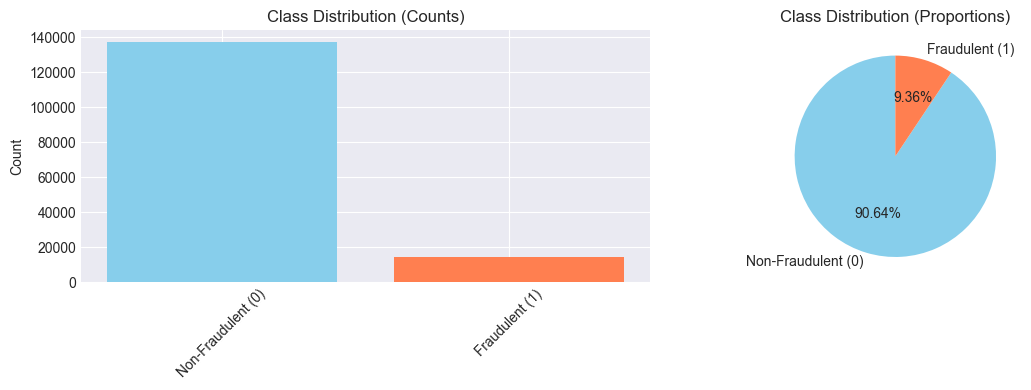

In [25]:
# Analyze class distribution
class_counts = fraud_df['class'].value_counts()
class_proportions = fraud_df['class'].value_counts(normalize=True)

print("Class Distribution:")
print(f"Non-fraudulent (0): {class_counts[0]:,} ({class_proportions[0]*100:.2f}%)")
print(f"Fraudulent (1): {class_counts[1]:,} ({class_proportions[1]*100:.2f}%)")
print(f"\nImbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
axes[0].bar(['Non-Fraudulent (0)', 'Fraudulent (1)'], class_counts.values, color=['skyblue', 'coral'])
axes[0].set_title('Class Distribution (Counts)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(class_counts.values, labels=['Non-Fraudulent (0)', 'Fraudulent (1)'], 
            autopct='%1.2f%%', startangle=90, colors=['skyblue', 'coral'])
axes[1].set_title('Class Distribution (Proportions)')

plt.tight_layout()
save_plot(fig, 'fraud_class_distribution.png')
plt.show()


## 4. Univariate Analysis


In [26]:
# Numerical features summary statistics
numerical_cols = ['purchase_value', 'age']
print("Numerical Features Summary:")
print(fraud_df[numerical_cols].describe())


Numerical Features Summary:
       purchase_value            age
count   151112.000000  151112.000000
mean        36.935372      33.140704
std         18.322762       8.617733
min          9.000000      18.000000
25%         22.000000      27.000000
50%         35.000000      33.000000
75%         49.000000      39.000000
max        154.000000      76.000000


Plot saved to: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/outputs/eda/fraud-data/fraud_numerical_features_distribution.png


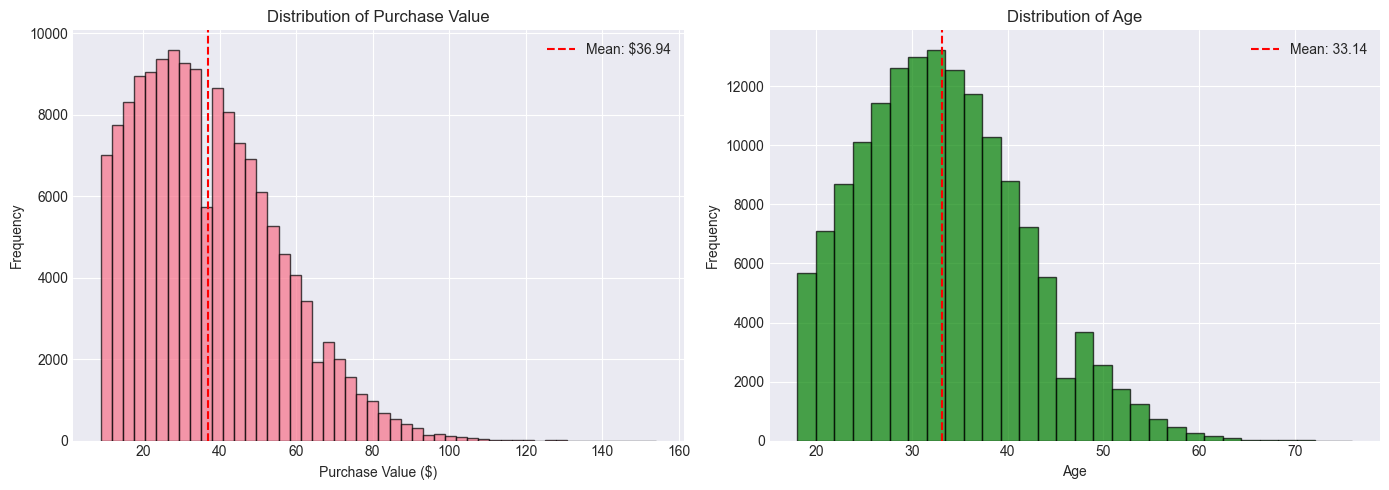

In [27]:
# Distribution of numerical features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Purchase value distribution
axes[0].hist(fraud_df['purchase_value'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Purchase Value')
axes[0].set_xlabel('Purchase Value ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(fraud_df['purchase_value'].mean(), color='red', linestyle='--', label=f'Mean: ${fraud_df["purchase_value"].mean():.2f}')
axes[0].legend()

# Age distribution
axes[1].hist(fraud_df['age'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution of Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')
axes[1].axvline(fraud_df['age'].mean(), color='red', linestyle='--', label=f'Mean: {fraud_df["age"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
save_plot(fig, 'fraud_numerical_features_distribution.png')
plt.show()


In [28]:
# Categorical features analysis
categorical_cols = ['source', 'browser', 'sex']

for col in categorical_cols:
    print(f"\n{col.upper()} Distribution:")
    print(fraud_df[col].value_counts())
    print(f"\n{col.upper()} Distribution by Class:")
    print(pd.crosstab(fraud_df[col], fraud_df['class'], normalize='index') * 100)



SOURCE Distribution:
source
SEO       60615
Ads       59881
Direct    30616
Name: count, dtype: int64

SOURCE Distribution by Class:
class           0          1
source                      
Ads     90.793407   9.206593
Direct  89.463026  10.536974
SEO     91.071517   8.928483

BROWSER Distribution:
browser
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: count, dtype: int64

BROWSER Distribution by Class:
class            0         1
browser                     
Chrome   90.120784  9.879216
FireFox  90.483543  9.516457
IE       91.322460  8.677540
Opera    91.077258  8.922742
Safari   90.979852  9.020148

SEX Distribution:
sex
M    88293
F    62819
Name: count, dtype: int64

SEX Distribution by Class:
class          0         1
sex                       
F      90.899250  9.100750
M      90.447714  9.552286


Plot saved to: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/outputs/eda/fraud-data/fraud_categorical_features_distribution.png


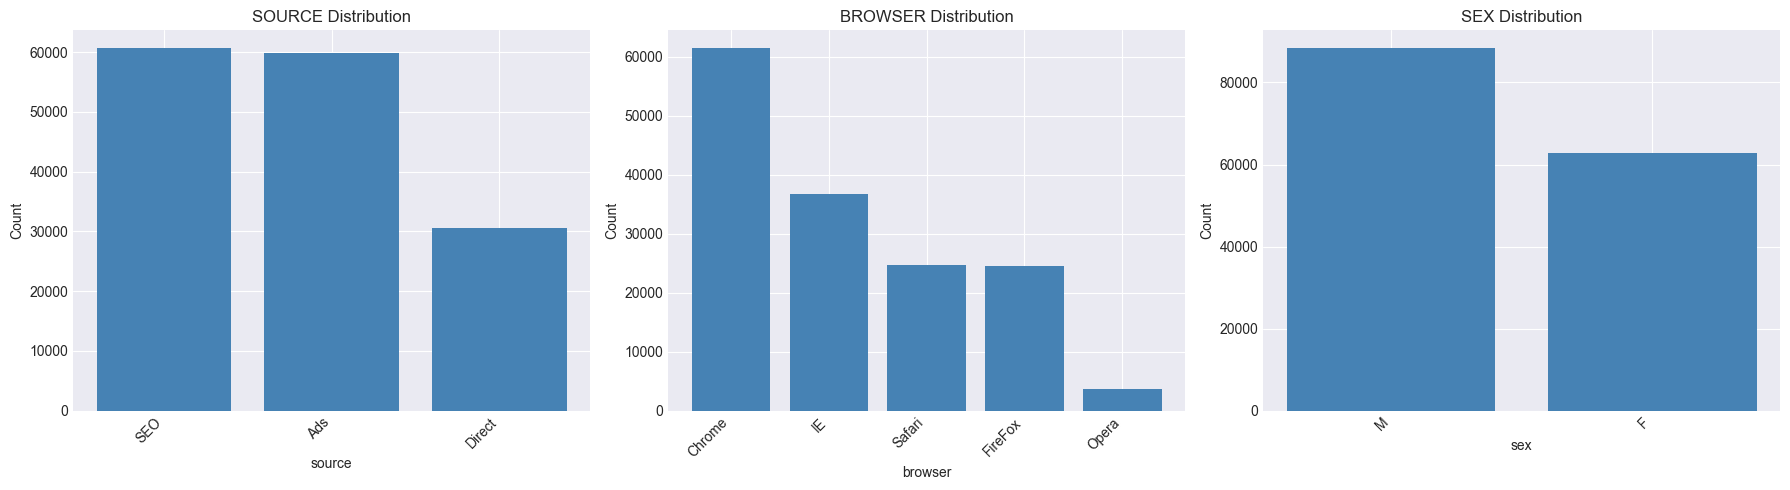

In [29]:
# Visualize categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(categorical_cols):
    value_counts = fraud_df[col].value_counts()
    axes[idx].bar(range(len(value_counts)), value_counts.values, color='steelblue')
    axes[idx].set_title(f'{col.upper()} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')

plt.tight_layout()
save_plot(fig, 'fraud_categorical_features_distribution.png')
plt.show()


## 5. Bivariate Analysis


Plot saved to: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/outputs/eda/fraud-data/fraud_purchase_value_by_class.png


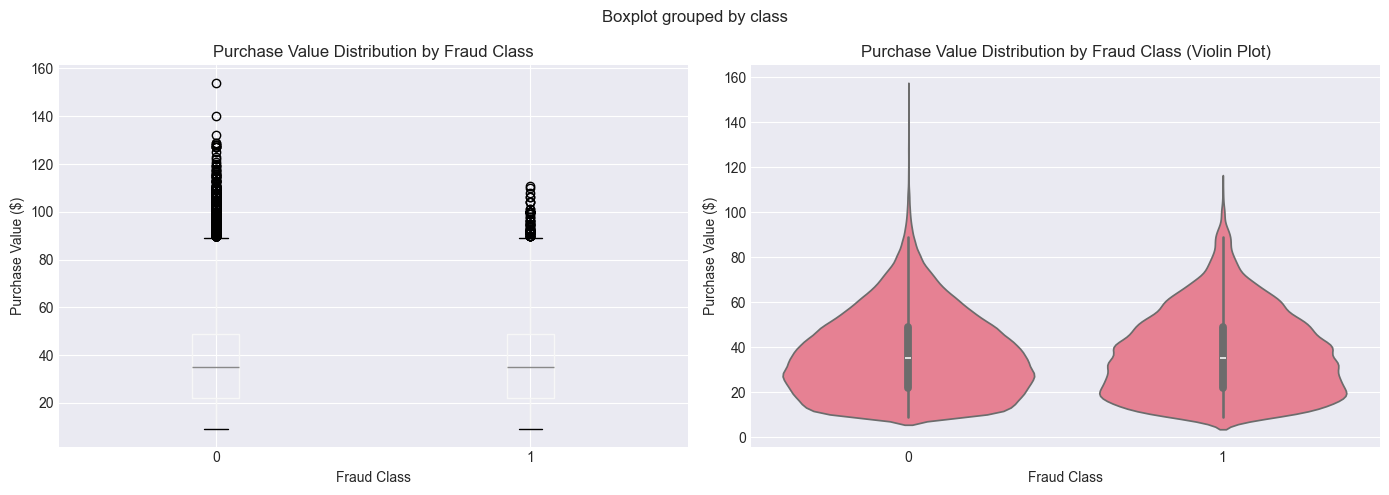


Purchase Value Statistics by Class:
          count       mean        std  min   25%   50%   75%    max
class                                                              
0      136961.0  36.929418  18.315064  9.0  22.0  35.0  49.0  154.0
1       14151.0  36.993004  18.397654  9.0  22.0  35.0  49.0  111.0


In [30]:
# Analyze relationships between features and target variable
# Purchase value by fraud class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
fraud_df.boxplot(column='purchase_value', by='class', ax=axes[0])
axes[0].set_title('Purchase Value Distribution by Fraud Class')
axes[0].set_xlabel('Fraud Class')
axes[0].set_ylabel('Purchase Value ($)')

# Violin plot for better distribution view
import seaborn as sns
sns.violinplot(data=fraud_df, x='class', y='purchase_value', ax=axes[1])
axes[1].set_title('Purchase Value Distribution by Fraud Class (Violin Plot)')
axes[1].set_xlabel('Fraud Class')
axes[1].set_ylabel('Purchase Value ($)')

plt.tight_layout()
save_plot(fig, 'fraud_purchase_value_by_class.png')
plt.show()

# Statistical summary by class
print("\nPurchase Value Statistics by Class:")
print(fraud_df.groupby('class')['purchase_value'].describe())


Plot saved to: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/outputs/eda/fraud-data/fraud_age_by_class.png


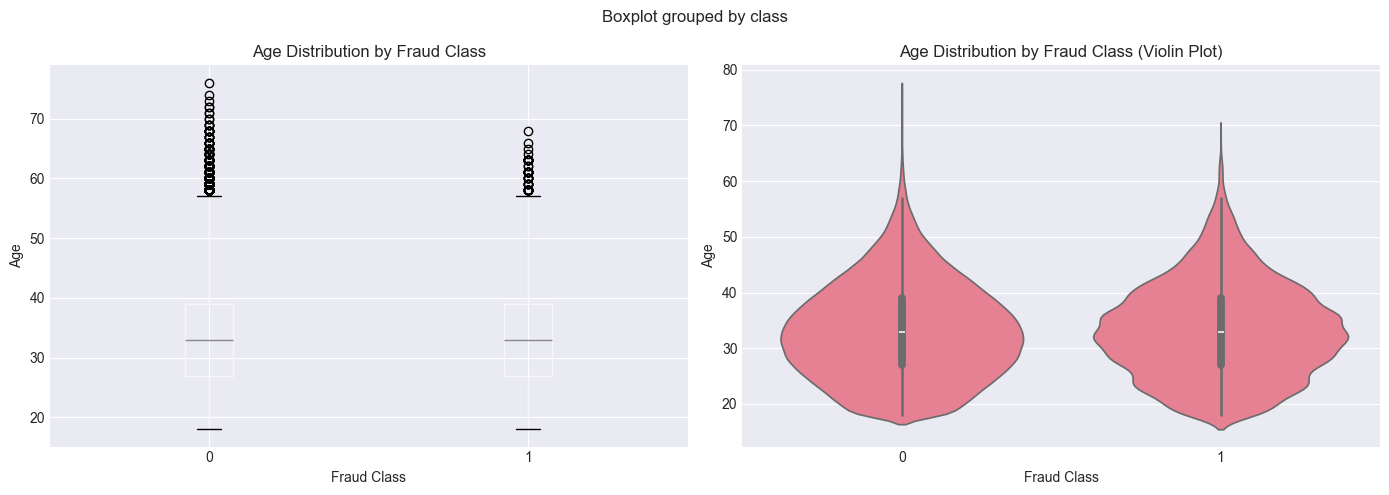


Age Statistics by Class:
          count       mean       std   min   25%   50%   75%   max
class                                                             
0      136961.0  33.122356  8.622678  18.0  27.0  33.0  39.0  76.0
1       14151.0  33.318281  8.568001  18.0  27.0  33.0  39.0  68.0


In [31]:
# Age by fraud class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fraud_df.boxplot(column='age', by='class', ax=axes[0])
axes[0].set_title('Age Distribution by Fraud Class')
axes[0].set_xlabel('Fraud Class')
axes[0].set_ylabel('Age')

sns.violinplot(data=fraud_df, x='class', y='age', ax=axes[1])
axes[1].set_title('Age Distribution by Fraud Class (Violin Plot)')
axes[1].set_xlabel('Fraud Class')
axes[1].set_ylabel('Age')

plt.tight_layout()
save_plot(fig, 'fraud_age_by_class.png')
plt.show()

print("\nAge Statistics by Class:")
print(fraud_df.groupby('class')['age'].describe())


Plot saved to: /Users/naomi/Improved detection of fraud cases for e-commerce and bank transactions/outputs/eda/fraud-data/fraud_rate_by_categorical_features.png


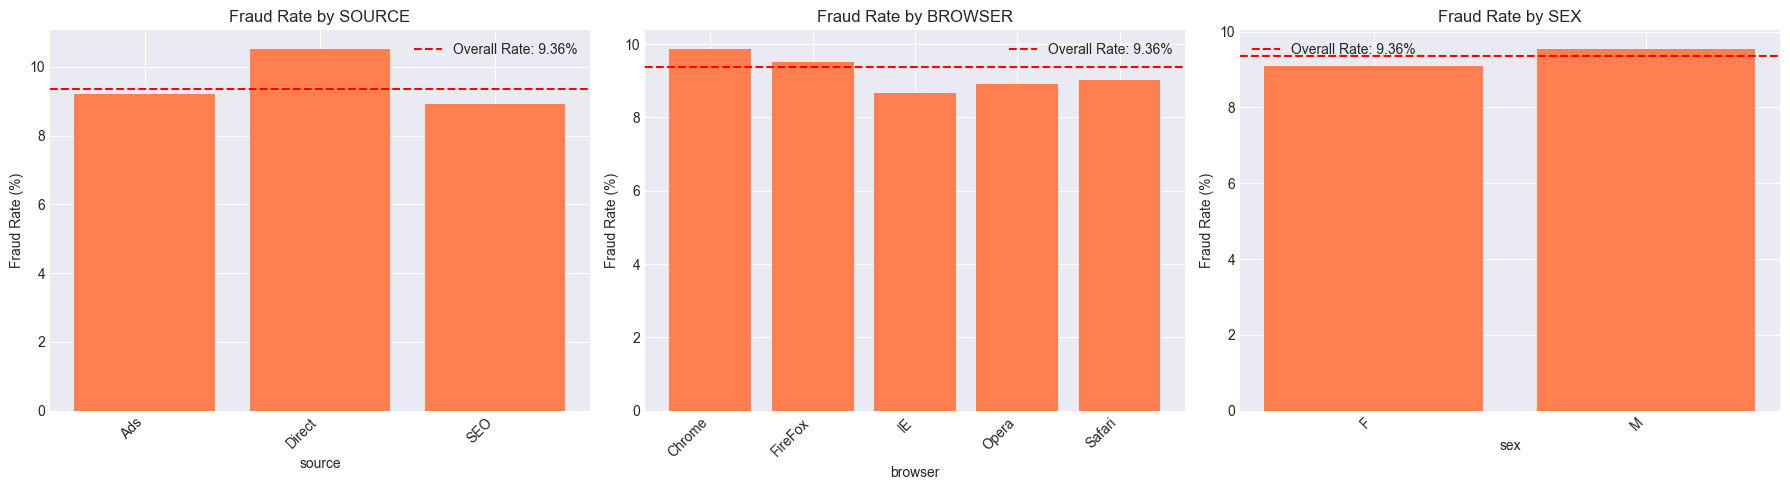

In [32]:
# Fraud rate by categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(categorical_cols):
    fraud_rate = fraud_df.groupby(col)['class'].mean() * 100
    axes[idx].bar(range(len(fraud_rate)), fraud_rate.values, color='coral')
    axes[idx].set_title(f'Fraud Rate by {col.upper()}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fraud Rate (%)')
    axes[idx].set_xticks(range(len(fraud_rate)))
    axes[idx].set_xticklabels(fraud_rate.index, rotation=45, ha='right')
    axes[idx].axhline(fraud_df['class'].mean() * 100, color='red', linestyle='--', 
                      label=f'Overall Rate: {fraud_df["class"].mean()*100:.2f}%')
    axes[idx].legend()

plt.tight_layout()
save_plot(fig, 'fraud_rate_by_categorical_features.png')
plt.show()


In [33]:
# Convert IP addresses to integer format for range-based lookup
def ip_to_int(ip_str):
    """Convert IP address string to integer"""
    try:
        return int(ipaddress.IPv4Address(ip_str))
    except:
        return None

# Convert IP addresses in fraud data
fraud_df['ip_address_int'] = fraud_df['ip_address'].apply(ip_to_int)

# Check conversion
print(f"Successfully converted {fraud_df['ip_address_int'].notna().sum()} IP addresses")
print(f"Failed conversions: {fraud_df['ip_address_int'].isna().sum()}")

# Sample converted IPs
print("\nSample IP conversions:")
print(fraud_df[['ip_address', 'ip_address_int']].head(10))


Successfully converted 0 IP addresses
Failed conversions: 151112

Sample IP conversions:
     ip_address ip_address_int
0  7.327584e+08           None
1  3.503114e+08           None
2  2.621474e+09           None
3  3.840542e+09           None
4  4.155831e+08           None
5  2.809315e+09           None
6  3.987484e+09           None
7  1.692459e+09           None
8  3.719094e+09           None
9  3.416747e+08           None


In [34]:
# Convert IP ranges in country mapping to integers
ip_country_df['lower_bound_int'] = ip_country_df['lower_bound_ip_address'].apply(ip_to_int)
ip_country_df['upper_bound_int'] = ip_country_df['upper_bound_ip_address'].apply(ip_to_int)

print("IP Country Mapping after conversion:")
print(ip_country_df.head())
print(f"\nShape: {ip_country_df.shape}")


IP Country Mapping after conversion:
   lower_bound_ip_address  upper_bound_ip_address    country lower_bound_int  \
0              16777216.0                16777471  Australia            None   
1              16777472.0                16777727      China            None   
2              16777728.0                16778239      China            None   
3              16778240.0                16779263  Australia            None   
4              16779264.0                16781311      China            None   

   upper_bound_int  
0         16777471  
1         16777727  
2         16778239  
3         16779263  
4         16781311  

Shape: (138846, 5)


In [35]:
# Merge fraud data with country mapping using range-based lookup
def find_country(ip_int, ip_country_df):
    """Find country for an IP address using range-based lookup"""
    if pd.isna(ip_int):
        return None
    
    # Find the country where IP falls within the range
    mask = (ip_country_df['lower_bound_int'] <= ip_int) & (ip_country_df['upper_bound_int'] >= ip_int)
    matches = ip_country_df[mask]
    
    if len(matches) > 0:
        return matches.iloc[0]['country']
    return None

# Apply country lookup
print("Matching IP addresses to countries...")
fraud_df['country'] = fraud_df['ip_address_int'].apply(lambda x: find_country(x, ip_country_df))

print(f"Matched countries for {fraud_df['country'].notna().sum()} IP addresses")
print(f"Unmatched: {fraud_df['country'].isna().sum()}")

# Sample results
print("\nSample country mappings:")
print(fraud_df[['ip_address', 'country', 'class']].head(10))


Matching IP addresses to countries...
Matched countries for 0 IP addresses
Unmatched: 151112

Sample country mappings:
     ip_address country  class
0  7.327584e+08    None      0
1  3.503114e+08    None      0
2  2.621474e+09    None      1
3  3.840542e+09    None      0
4  4.155831e+08    None      0
5  2.809315e+09    None      0
6  3.987484e+09    None      0
7  1.692459e+09    None      0
8  3.719094e+09    None      0
9  3.416747e+08    None      0


In [38]:
# Analyze fraud patterns by country
if fraud_df['country'].notna().sum() > 0:
    country_fraud_stats = fraud_df.groupby('country').agg({
        'class': ['count', 'sum', 'mean']
    }).reset_index()
    country_fraud_stats.columns = ['country', 'total_transactions', 'fraud_count', 'fraud_rate']
    country_fraud_stats['fraud_rate'] = country_fraud_stats['fraud_rate'] * 100
    country_fraud_stats = country_fraud_stats.sort_values('fraud_rate', ascending=False)
    
    print("Top 20 Countries by Fraud Rate:")
    print(country_fraud_stats.head(20))
    
    # Visualize fraud by country (top 20)
    top_countries = country_fraud_stats.head(20)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].barh(range(len(top_countries)), top_countries['fraud_rate'].values, color='coral')
    axes[0].set_yticks(range(len(top_countries)))
    axes[0].set_yticklabels(top_countries['country'])
    axes[0].set_xlabel('Fraud Rate (%)')
    axes[0].set_title('Fraud Rate by Country (Top 20)')
    axes[0].invert_yaxis()
    
    axes[1].barh(range(len(top_countries)), top_countries['total_transactions'].values, color='steelblue')
    axes[1].set_yticks(range(len(top_countries)))
    axes[1].set_yticklabels(top_countries['country'])
    axes[1].set_xlabel('Total Transactions')
    axes[1].set_title('Total Transactions by Country (Top 20)')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    save_plot(fig, 'fraud_by_country.png')
    plt.show()
else:
    print("No country mappings available for analysis")


No country mappings available for analysis


## 7. Summary and Next Steps

### Key Findings:
1. **Class Imbalance**: [Document the imbalance ratio found]
2. **Missing Values**: [Document any missing values and handling strategy]
3. **Key Patterns**: [Document any notable patterns discovered]
4. **Geolocation**: [Document country-level fraud patterns]

### Next Steps:
- Feature engineering (time-based features, transaction frequency)
- Data transformation (scaling, encoding)
- Handle class imbalance for modeling
